# import

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
    rc('font', family=font_name)

In [7]:
con_08 = pd.read_csv('../data/데이터스쿨3차_2308월/데이터스쿨_3차_콘텐츠_2308.csv', encoding = 'cp949', sep = '\t')
con_09 = pd.read_csv('../data/데이터스쿨3차_2309월/데이터스쿨_3차_콘텐츠_2309.csv', encoding = 'cp949', sep = '\t')
vod_id = pd.read_csv('../data/전처리data/vod_id_origin.csv', encoding = 'cp949')

In [8]:
# 8,9월 데이터 합치기
con_89 = pd.concat([con_08, con_09], ignore_index=True)
con_89.head(3)

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt
0,65968000,(영어더빙)핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,0:01,20230813071155
1,65968000,(영어더빙)핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,0:01,20230813071215
2,66056000,라바 키즈동요(한국어) Part4,라바 키즈동요(한국어) Part4 17회,키즈,기타,징글벨 크리스마스. 안녕하신가 친구들! 메리 크리스마스~ 징글벨 크리스마스 징글벨 ...,"엘로우,레드",0:02,20230808085440


# 전처리

In [11]:
from pandas._libs.tslibs.offsets import Hour
def preprocessing(data):
  df = data.copy()
  # 특수 문자 정리
  ## 예고편 제거
  df = df[~df['super_asset_nm'].str.contains(r'\(예고편\)|\(예고\)', regex=True)]
  
  # series_nm 괄호와 그 안의 내용 제거
  df['series_nm'] = df['series_nm'].str.replace(r'\([^()]*\)', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\[[^\[\]]*\]', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\.\.\.', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'…', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace('-', ' ')
  df['series_nm'] = df['series_nm'].str.rstrip('.')

  # super_asset_nm 변경
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\([^()]*\)', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\[[^\[\]]*\]', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'\.\.\.', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'…', '', regex=True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace('-', ' ')
  df['super_asset_nm'] = df['super_asset_nm'].str.rstrip('.')

  # 'series_nm'이 null인 경우, 'super_asset_nm'의 값으로 대체
  df['series_nm'].fillna(df['super_asset_nm'], inplace=True)

  # 회, 회., 화, 실사판, 무삭제 제거
  df['series_nm'] = df['series_nm'].str.replace(r'무삭제판|무삭제', '', regex = True)
  df['series_nm'] = df['series_nm'].str.replace(r'실사판', '', regex = True)
  df['series_nm'] = df['series_nm'].str.replace(r'\d+회$', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\d+회\.', '', regex=True)
  df['series_nm'] = df['series_nm'].str.replace(r'\d+화$', '', regex = True)
  df['series_nm'] = df['series_nm'].str.strip()
  df['series_nm'] = df['series_nm'].str.rstrip('.')

  # 무삭제 제거
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'무삭제판|무삭제', '', regex = True)
  df['super_asset_nm'] = df['super_asset_nm'].str.replace(r'실사판', '', regex = True)
  df['super_asset_nm'] = df['super_asset_nm'].str.strip()
  df['super_asset_nm'] = df['super_asset_nm'].str.rstrip('.')

  # disp_rtm 문자열을 분 단위로 변경
  def convert_runtime(runtime_str):
    # 입력값이 NaN이면 0 반환
    if pd.isna(runtime_str):
        return 0

    hours = int(runtime_str.split(':')[0])
    minutes = int(runtime_str.split(':')[1])
    total_minutes = hours * 60 + minutes
    return total_minutes

  df['disp_rtm'] = df['disp_rtm'].apply(convert_runtime)

  # 런타임 0분인 것 제거
  df = df[df['disp_rtm'] != 0]

  # 예고편 제거
  # df = df[~df['series_nm'].str.contains(r'\(예고편\)|\(예고\)', regex=True)]

  # # 예약구매, 사전구매 제거
  # df = df[~df['series_nm'].str.contains('예약구매|사전구매')]

  # 00회가 포함된 행은 런타임이 0또는 1이므로 제거
  df = df[~df['series_nm'].str.contains(r'\b00회\b')]

  # 셋탑번호가 66056000인 것 삭제 - content 에서 이상치 아이디로 판별
  df = df[df['subsr'] != 66056000]

  df['category'] = df['ct_cl'].apply(lambda x : x if x in ['영화', '키즈'] else 'TV프로그램')
  df['rename'] = df['series_nm'].apply(lambda x : x.replace(' ', '') if isinstance(x, str) else x)

  return df

In [12]:
df = preprocessing(con_89)
df.head(1)

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071155,키즈,핑크퐁동물동요


In [13]:
# id 병합
id = vod_id[['rename', 'Category', 'vod_id']]
id.columns = ['rename', 'category', 'vod_id']
id

,rename,category,vod_id
0,와이낫크루뜻밖의여행,TV프로그램,0
1,그레이트뷰티,영화,1
2,해안선,영화,2
3,아는형님,TV프로그램,3
4,베놈,영화,4
...,...,...,...
4710,베놈2:렛데어비카니지,영화,4710
4711,성월동화,영화,4711
4712,다큐인사이트코드블루,TV프로그램,4712
4713,캠프제로베이스원,TV프로그램,4713


In [14]:
df1 = df.merge(id, on = ['rename', 'category'], how = 'left')
df1

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename,vod_id
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071155,키즈,핑크퐁동물동요,882
1,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요 20회,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071215,키즈,핑크퐁동물동요,882
2,63086000,지니강이 플러스 시즌7,지니강이 플러스 시즌7. 26회,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,20230827145542,키즈,지니강이플러스시즌7,1622
3,63086000,지니강이 플러스 시즌9,지니강이 플러스 시즌9. 26회,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,20230827152417,키즈,지니강이플러스시즌9,2043
4,62733000,엘리가간다 시즌12,엘리가간다 시즌12 25회,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,20230816112816,키즈,엘리가간다시즌12,1958
...,...,...,...,...,...,...,...,...,...,...,...,...
19163,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121656,키즈,슈퍼토끼,544
19164,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121646,키즈,슈퍼토끼,544
19165,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544
19166,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544


In [15]:
df1[df1['vod_id'].isna()]

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename,vod_id


In [16]:
# watched : 유저 - 프로그램당 개수
df2 =  df1.groupby(['subsr', 'super_asset_nm', 'vod_id']).size().reset_index(name='watched').sort_values(by='watched', ascending=False)
df2

,subsr,super_asset_nm,vod_id,watched
5855,64720000,낭만닥터 김사부3 16회,336,80
4624,64154000,최강 배달꾼 16회,754,54
890,60496000,연인 파트1 10회,1166,47
493,60320000,더 문,2866,40
2089,61136000,치한적 새엄마의 몰입섹스,3708,35
...,...,...,...,...
4020,64081000,큐브,2642,1
4017,64081000,천룡팔부: 교봉전,2575,1
4015,64081000,정무문: 더 파이널,2981,1
4014,64081000,인어공주,1215,1


In [17]:
# series_nm과 super_asset_nm에서 회차 제거
df33 = df1.copy()

df33['super_asset_nm'] = df33['super_asset_nm'].str.replace(r'실사판', '', regex = True)
df33['super_asset_nm'] = df33['super_asset_nm'].str.replace(r'\d+회$', '', regex=True)
df33['super_asset_nm'] = df33['super_asset_nm'].str.replace(r'\d+회\.', '', regex=True)
df33['super_asset_nm'] = df33['super_asset_nm'].str.replace(r'\d+화$', '', regex = True)
df33['super_asset_nm'] = df33['super_asset_nm'].str.strip()
df33['super_asset_nm'] = df33['super_asset_nm'].str.rstrip('.')

df33

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename,vod_id
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071155,키즈,핑크퐁동물동요,882
1,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071215,키즈,핑크퐁동물동요,882
2,63086000,지니강이 플러스 시즌7,지니강이 플러스 시즌7,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,20230827145542,키즈,지니강이플러스시즌7,1622
3,63086000,지니강이 플러스 시즌9,지니강이 플러스 시즌9,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,20230827152417,키즈,지니강이플러스시즌9,2043
4,62733000,엘리가간다 시즌12,엘리가간다 시즌12,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,20230816112816,키즈,엘리가간다시즌12,1958
...,...,...,...,...,...,...,...,...,...,...,...,...
19163,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121656,키즈,슈퍼토끼,544
19164,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121646,키즈,슈퍼토끼,544
19165,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544
19166,64551000,슈퍼 토끼,슈퍼 토끼,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,20230930121655,키즈,슈퍼토끼,544


In [19]:
# watched_all 생성 (프로그램(회차 x) 당 총 클릭 횟수)
df4 = df33.groupby(['series_nm', 'vod_id']).size().reset_index(name='watched_all').sort_values(by='watched_all', ascending=False)
df4

,series_nm,vod_id,watched_all
965,범죄도시3,2537,526
1557,연인 파트1,1166,393
678,런닝맨,296,374
1526,엘리멘탈,2288,303
348,꼬리에꼬리를무는그날이야기,8,265
...,...,...,...
1268,쉐어TV,4678,1
259,그 여자의 죄가 아니다,1093,1
1265,순천부: 국자감살인사건,4141,1
1263,순정에 반하다,2005,1


In [20]:
df5 = df33.groupby(['subsr']).size().reset_index(name='watched_cnt').sort_values(by='watched_cnt', ascending=False)
df5

,subsr,watched_cnt
333,64154000,840
361,64385000,831
47,60326000,757
92,60939000,675
64,60593000,631
...,...,...
532,65542000,1
170,61774000,1
702,66448000,1
165,61760000,1


# 병합

In [21]:
df2.head()

,subsr,super_asset_nm,vod_id,watched
5855,64720000,낭만닥터 김사부3 16회,336,80
4624,64154000,최강 배달꾼 16회,754,54
890,60496000,연인 파트1 10회,1166,47
493,60320000,더 문,2866,40
2089,61136000,치한적 새엄마의 몰입섹스,3708,35


In [22]:
df33.head(1)

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,category,rename,vod_id
0,65968000,핑크퐁 동물 동요,핑크퐁 동물 동요,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,20230813071155,키즈,핑크퐁동물동요,882


In [23]:
# 병합할 데이터
df3 = df33[['subsr', 'series_nm', 'rename', 'super_asset_nm', 'vod_id', 'ct_cl', 'genre_of_ct_cl', 'category']].drop_duplicates().reset_index(drop = True)
df3.head()

,subsr,series_nm,rename,super_asset_nm,vod_id,ct_cl,genre_of_ct_cl,category
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요,882,키즈,기타,키즈
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈
2,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9,2043,키즈,기타,키즈
3,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12,1958,키즈,기타,키즈
4,63086000,지니강이 플러스 시즌8,지니강이플러스시즌8,지니강이 플러스 시즌8,1596,키즈,기타,키즈


In [24]:
# watched 병합
df6 = df3.merge(df2, on = ['subsr', 'vod_id'], how='left')
df6

,subsr,series_nm,rename,super_asset_nm_x,vod_id,ct_cl,genre_of_ct_cl,category,super_asset_nm_y,watched
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요,882,키즈,기타,키즈,핑크퐁 동물 동요 20회,2
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 2회,1
2,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 26회,1
3,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9,2043,키즈,기타,키즈,지니강이 플러스 시즌9. 26회,1
4,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12,1958,키즈,기타,키즈,엘리가간다 시즌12 25회,1
...,...,...,...,...,...,...,...,...,...,...
9399,64982000,포켓몬스터 XY and Z,포켓몬스터XYandZ,포켓몬스터 XY and Z,2918,키즈,애니메이션,키즈,포켓몬스터 XY and Z 24회,1
9400,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3,3135,키즈,애니메이션,키즈,포켓몬스터 썬 앤 문 3 36회,1
9401,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕,10,키즈,오락,키즈,라바 인 뉴욕 29회,1
9402,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1,3468,키즈,학습,키즈,사이틴 시즌1 52회,1


In [25]:
df6[df6['watched'].isna()]

,subsr,series_nm,rename,super_asset_nm_x,vod_id,ct_cl,genre_of_ct_cl,category,super_asset_nm_y,watched


In [26]:
df4

,series_nm,vod_id,watched_all
965,범죄도시3,2537,526
1557,연인 파트1,1166,393
678,런닝맨,296,374
1526,엘리멘탈,2288,303
348,꼬리에꼬리를무는그날이야기,8,265
...,...,...,...
1268,쉐어TV,4678,1
259,그 여자의 죄가 아니다,1093,1
1265,순천부: 국자감살인사건,4141,1
1263,순정에 반하다,2005,1


In [27]:
# watched_all 병합
df7 = df6.merge(df4, on = ['series_nm', 'vod_id'], how='left')
df7

,subsr,series_nm,rename,super_asset_nm_x,vod_id,ct_cl,genre_of_ct_cl,category,super_asset_nm_y,watched,watched_all
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요,882,키즈,기타,키즈,핑크퐁 동물 동요 20회,2,2
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 2회,1,2
2,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 26회,1,2
3,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9,2043,키즈,기타,키즈,지니강이 플러스 시즌9. 26회,1,1
4,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12,1958,키즈,기타,키즈,엘리가간다 시즌12 25회,1,2
...,...,...,...,...,...,...,...,...,...,...,...
9399,64982000,포켓몬스터 XY and Z,포켓몬스터XYandZ,포켓몬스터 XY and Z,2918,키즈,애니메이션,키즈,포켓몬스터 XY and Z 24회,1,1
9400,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3,3135,키즈,애니메이션,키즈,포켓몬스터 썬 앤 문 3 36회,1,1
9401,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕,10,키즈,오락,키즈,라바 인 뉴욕 29회,1,1
9402,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1,3468,키즈,학습,키즈,사이틴 시즌1 52회,1,1


In [28]:
df7[df7['watched_all'].isna()]

,subsr,series_nm,rename,super_asset_nm_x,vod_id,ct_cl,genre_of_ct_cl,category,super_asset_nm_y,watched,watched_all


In [29]:
df5.head(5)

,subsr,watched_cnt
333,64154000,840
361,64385000,831
47,60326000,757
92,60939000,675
64,60593000,631


In [30]:
# watched_all 병합
df8 = df7.merge(df5, on = ['subsr'], how='left')
df8

,subsr,series_nm,rename,super_asset_nm_x,vod_id,ct_cl,genre_of_ct_cl,category,super_asset_nm_y,watched,watched_all,watched_cnt
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요,882,키즈,기타,키즈,핑크퐁 동물 동요 20회,2,2,2
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 2회,1,2,131
2,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 26회,1,2,131
3,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9,2043,키즈,기타,키즈,지니강이 플러스 시즌9. 26회,1,1,131
4,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12,1958,키즈,기타,키즈,엘리가간다 시즌12 25회,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
9399,64982000,포켓몬스터 XY and Z,포켓몬스터XYandZ,포켓몬스터 XY and Z,2918,키즈,애니메이션,키즈,포켓몬스터 XY and Z 24회,1,1,55
9400,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3,3135,키즈,애니메이션,키즈,포켓몬스터 썬 앤 문 3 36회,1,1,17
9401,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕,10,키즈,오락,키즈,라바 인 뉴욕 29회,1,1,2
9402,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1,3468,키즈,학습,키즈,사이틴 시즌1 52회,1,1,131


In [31]:
df8[df8['watched_cnt'].isna()]

,subsr,series_nm,rename,super_asset_nm_x,vod_id,ct_cl,genre_of_ct_cl,category,super_asset_nm_y,watched,watched_all,watched_cnt


In [32]:
import numpy as np
def scoring(df):
  N = df['watched_all']
  L = df['watched_cnt']
  n = df['watched']
  lam = np.log(2) / 2
  w1 = 1 - np.exp(-1 * lam * N)
  data = pd.DataFrame([N, L]).T
  def custom_weight(data):
    if data['watched_cnt'] < data['watched_all']:
      return data['watched_all'] / data['watched_cnt']
    else:
      return 1

  w2 = data.apply(custom_weight, axis = 1)

  score = (n / N) * w1 * w2

  return score

In [38]:
df8['cpaper_score'] = scoring(df8)
df8

,subsr,series_nm,rename,super_asset_nm_x,vod_id,ct_cl,genre_of_ct_cl,category,super_asset_nm_y,watched,watched_all,watched_cnt,score,cpaper_score
0,65968000,핑크퐁 동물 동요,핑크퐁동물동요,핑크퐁 동물 동요,882,키즈,기타,키즈,핑크퐁 동물 동요 20회,2,2,2,0.500000,0.500000
1,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 2회,1,2,131,0.250000,0.250000
2,63086000,지니강이 플러스 시즌7,지니강이플러스시즌7,지니강이 플러스 시즌7,1622,키즈,기타,키즈,지니강이 플러스 시즌7. 26회,1,2,131,0.250000,0.250000
3,63086000,지니강이 플러스 시즌9,지니강이플러스시즌9,지니강이 플러스 시즌9,2043,키즈,기타,키즈,지니강이 플러스 시즌9. 26회,1,1,131,0.292893,0.292893
4,62733000,엘리가간다 시즌12,엘리가간다시즌12,엘리가간다 시즌12,1958,키즈,기타,키즈,엘리가간다 시즌12 25회,1,2,2,0.250000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9399,64982000,포켓몬스터 XY and Z,포켓몬스터XYandZ,포켓몬스터 XY and Z,2918,키즈,애니메이션,키즈,포켓몬스터 XY and Z 24회,1,1,55,0.292893,0.292893
9400,66864000,포켓몬스터 썬 앤 문 3,포켓몬스터썬앤문3,포켓몬스터 썬 앤 문 3,3135,키즈,애니메이션,키즈,포켓몬스터 썬 앤 문 3 36회,1,1,17,0.292893,0.292893
9401,59917000,라바 인 뉴욕,라바인뉴욕,라바 인 뉴욕,10,키즈,오락,키즈,라바 인 뉴욕 29회,1,1,2,0.292893,0.292893
9402,63086000,사이틴 시즌1,사이틴시즌1,사이틴 시즌1,3468,키즈,학습,키즈,사이틴 시즌1 52회,1,1,131,0.292893,0.292893


In [43]:
content_paper_score = df8[['subsr', 'series_nm', 'vod_id', 'cpaper_score']]
content_paper_score = content_paper_score.merge(df3[['series_nm', 'vod_id', 'ct_cl', 'genre_of_ct_cl']].drop_duplicates(), on = ['series_nm', 'vod_id'], how = 'left')
content_paper_score = content_paper_score.sort_values(by = 'subsr').reset_index(drop = True)
content_paper_score['category'] = content_paper_score['ct_cl'].apply(lambda x : x if x in ['영화', '키즈'] else 'TV프로그램')
content_paper_score

,subsr,series_nm,vod_id,cpaper_score,ct_cl,genre_of_ct_cl,category
0,59879000,나쁜엄마,3403,0.187500,TV드라마,기타,TV프로그램
1,59879000,소방서 옆 경찰서,2092,0.111110,TV드라마,기타,TV프로그램
2,59879000,낭만닥터 김사부2,1168,0.106201,TV드라마,기타,TV프로그램
3,59879000,소방서 옆 경찰서,2092,0.222220,TV드라마,기타,TV프로그램
4,59879000,신성한 이혼,1190,0.145833,TV드라마,기타,TV프로그램
...,...,...,...,...,...,...,...
9485,67160000,콘크리트 유토피아,2630,0.125000,영화,드라마,영화
9486,67160000,스파이더맨: 어크로스 더 유니버스,2147,0.124989,영화,애니메이션,영화
9487,67160000,메가로돈 2,4018,0.125000,영화,액션/어드벤쳐,영화
9488,67161000,스파이 코드명 포춘,3824,0.999989,영화,액션/어드벤쳐,영화


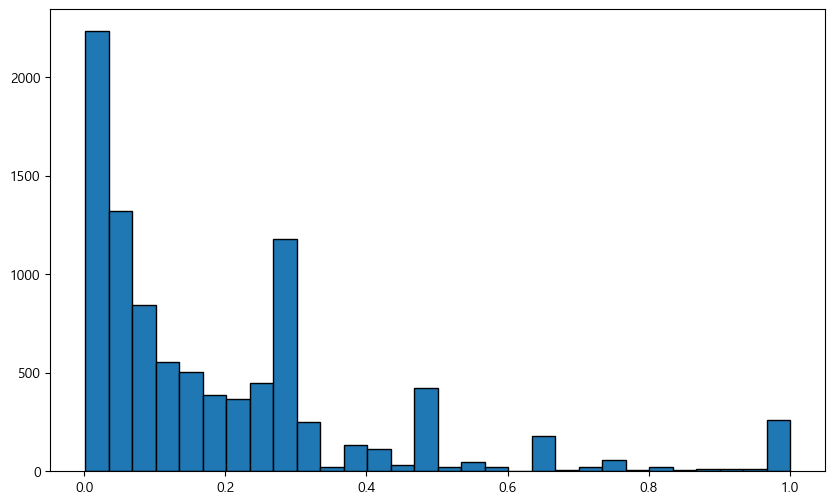

In [41]:
# plotting 환경 설정
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# 그래프가 노트북 안에 보이게 하기 위해
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(content_paper_score['cpaper_score'], bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.show()

In [44]:
content_paper_score.to_csv('../data/전처리data/content_paper_score.csv',encoding='cp949', index = 0)

# paper_plus 생성

In [56]:
plus = pd.read_csv('../data/전처리data/content_plus.csv', encoding='cp949')
plus.rename(columns={'score':'cpaper_score'}, inplace=True)
plus.head(1)

,subsr,series_nm,vod_id,ct_cl,genre_of_ct_cl,category,cpaper_score
0,66424000,나 혼자산다,432,TV 연예/오락,기타,TV프로그램,1


In [60]:
paper_plus = pd.concat([content_paper_score, plus], axis=0, join='outer').fillna({'cpaper_score': 1}).reset_index(drop=True)
paper_plus = paper_plus.sort_values(by = 'subsr').reset_index(drop = True)
paper_plus

,subsr,series_nm,vod_id,cpaper_score,ct_cl,genre_of_ct_cl,category
0,59879000,나쁜엄마,3403,0.187500,TV드라마,기타,TV프로그램
1,59879000,소방서 옆 경찰서,2092,0.111110,TV드라마,기타,TV프로그램
2,59879000,낭만닥터 김사부2,1168,0.106201,TV드라마,기타,TV프로그램
3,59879000,소방서 옆 경찰서,2092,0.222220,TV드라마,기타,TV프로그램
4,59879000,신성한 이혼,1190,0.145833,TV드라마,기타,TV프로그램
...,...,...,...,...,...,...,...
9686,67160000,스파이더맨: 어크로스 더 유니버스,2147,0.124989,영화,애니메이션,영화
9687,67160000,메가로돈 2,4018,0.125000,영화,액션/어드벤쳐,영화
9688,67160000,바비,3523,0.124998,영화,코미디,영화
9689,67161000,스파이 코드명 포춘,3824,0.999989,영화,액션/어드벤쳐,영화


In [61]:
paper_plus[paper_plus['cpaper_score'].isna()]

,subsr,series_nm,vod_id,cpaper_score,ct_cl,genre_of_ct_cl,category


In [62]:
paper_plus.to_csv('../data/전처리data/paper_plus.csv',encoding='cp949', index = 0)